# GAN Tutorial: Learning to Generate Data with Adversarial Networks

## What You'll Learn
- What are Generative Adversarial Networks (GANs) and why they're powerful
- How the Generator and Discriminator work together in an adversarial game
- How to implement a GAN model from scratch
- How to train the model and visualize the results

## What is a GAN?
A Generative Adversarial Network (GAN) is a type of generative model that uses two neural networks competing against each other:
- **Generator**: Tries to create fake data that looks real
- **Discriminator**: Tries to distinguish between real and fake data

Think of it like a game between a counterfeiter (Generator) and a detective (Discriminator)!

## The GAN Approach
GANs use an adversarial training process where the Generator and Discriminator improve together. The Generator learns to create increasingly realistic data, while the Discriminator becomes better at detecting fakes.

Let's dive in! 🚀


In [1]:
# PyTorch for deep learning
import torch
from torch import nn, optim
from torch.nn import functional as F

# For data visualization
import matplotlib.pyplot as plt
from pylab import rcParams

# For generating our dataset
from sklearn import datasets
import numpy as np

# For file operations
import os

# Set up plotting parameters
rcParams['figure.figsize'] = 8, 8
plt.ion()  # Interactive plotting

print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Using device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

All libraries imported successfully!
PyTorch version: 2.9.0+cu126
Using device: CUDA


## Step 2: Configuration and Setup

Let's set up our hyperparameters (settings that control how our model learns). These are like the "knobs" we can turn to adjust our model's behavior.


In [2]:
# ===== Dataset =====
DATASET = "mnist"  # "mnist" or "fashionmnist"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


# Training configuration
BATCH_SIZE = 128        # How many data points to process at once
EPOCHS = 100           # How many times to see the entire dataset
LOG_INTERVAL = 50      # How often to print progress updates

# Model architecture
INPUT_DIM = 2          # Our data has 2 dimensions (x, y coordinates)
NOISE_DIM = 2          # Dimension of noise input to generator
HIDDEN_DIM = 256       # Size of hidden layers in our neural networks

# GAN-specific hyperparameters
LR_G = 2e-4           # Learning rate for Generator
LR_D = 2e-4           # Learning rate for Discriminator
BETAS = (0.5, 0.999)

# ===== Image setup =====
IMG_SIZE = 28
CHANNELS = 1
Z_DIM = 100  # noise dim (типово 100)

# Visualization settings
SAVE_PLT_INTERVAL = 5   # How often to save plots (every 5 epochs)

# Set up device (use GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Configuration set up!")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Epochs: {EPOCHS}")
print(f"   Hidden dimension: {HIDDEN_DIM}")
print(f"   Generator learning rate: {LR_G}")
print(f"   Discriminator learning rate: {LR_D}")
print(f"   Device: {device}")


Device: cuda
Configuration set up!
   Batch size: 128
   Epochs: 100
   Hidden dimension: 256
   Generator learning rate: 0.0002
   Discriminator learning rate: 0.0002
   Device: cuda


## Step 3: Prepare Data Loaders

Data loaders help us feed data to our model in small batches during training. This is more memory-efficient than loading all data at once.


In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # щоб було [-1, 1]
])

if DATASET == "mnist":
    ds_full = datasets.MNIST("./data", train=True, download=True, transform=transform)
    ds_test = datasets.MNIST("./data", train=False, download=True, transform=transform)
elif DATASET == "fashionmnist":
    ds_full = datasets.FashionMNIST("./data", train=True, download=True, transform=transform)
    ds_test = datasets.FashionMNIST("./data", train=False, download=True, transform=transform)
else:
    raise ValueError("Unknown dataset")

# (опційно) validation split з train
val_ratio = 0.1
n_val = int(len(ds_full) * val_ratio)
n_tr = len(ds_full) - n_val
ds_train, ds_val = random_split(ds_full, [n_tr, n_val], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("Train/Val/Test:", len(ds_train), len(ds_val), len(ds_test))

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.56MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 130kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.4MB/s]

Train/Val/Test: 54000 6000 10000


## Step 5: Understanding the GAN Architecture

Now let's build our GAN model! The key idea is to have two competing neural networks:

### What is a Generator?
The **Generator** takes random noise as input and tries to create fake data that looks like our real data. It's like an artist trying to paint a convincing forgery.

### What is a Discriminator?
The **Discriminator** takes data (real or fake) as input and tries to determine whether it's real or fake. It's like an art expert trying to spot forgeries.

### The Adversarial Game
- Generator wants to fool the Discriminator
- Discriminator wants to catch the Generator
- They improve together in this competitive process!

Let's build them step by step:


In [4]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, channels=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 128, 7, 1, 0),  # 7x7
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),     # 14x14
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, channels, 4, 2, 1), # 28x28
            nn.Tanh()  # output in [-1,1] (бо Normalize)
        )

    def forward(self, z):
        return self.net(z)


print("Generator class defined!")
print("   This network will learn to create moon-shaped data from random noise.")


Generator class defined!
   This network will learn to create moon-shaped data from random noise.


In [5]:
class Discriminator(nn.Module):
    def __init__(self, channels=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(channels, 64, 4, 2, 1),   # 14x14
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1),        # 7x7
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 1, 7, 1, 0)          # 1x1
            # Без Sigmoid! (буде BCEWithLogitsLoss)
        )

    def forward(self, x):
        return self.net(x).view(-1, 1)  # logits

print("Discriminator class defined!")
print("   This network will learn to distinguish real from fake moon data.")


Discriminator class defined!
   This network will learn to distinguish real from fake moon data.


In [6]:
generator = Generator(Z_DIM, CHANNELS).to(device)
discriminator = Discriminator(CHANNELS).to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer_G = torch.optim.Adam(generator.parameters(), lr=LR_G, betas=BETAS)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=LR_D, betas=BETAS)

print("GAN models created!")
print(f"   Generator parameters: {sum(p.numel() for p in generator.parameters()):,}")
print(f"   Discriminator parameters: {sum(p.numel() for p in discriminator.parameters()):,}")
print(f"   Generator learning rate: {LR_G}")
print(f"   Discriminator learning rate: {LR_D}")
print(f"   Models moved to device: {device}")
print(f"   Models dtype: {next(generator.parameters()).dtype}")

# Let's see what our models look like
print("Generator architecture:")
print(generator)
print("Discriminator architecture:")
print(discriminator)

GAN models created!
   Generator parameters: 759,873
   Discriminator parameters: 138,817
   Generator learning rate: 0.0002
   Discriminator learning rate: 0.0002
   Models moved to device: cuda
   Models dtype: torch.float32
Generator architecture:
Generator(
  (net): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(7, 7), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): Tanh()
  )
)
Discriminator architecture:
Discriminator(
  (net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel

In [7]:
def train_discriminator(real_imgs):
    generator.train(); discriminator.train()
    bs = real_imgs.size(0)

    real_imgs = real_imgs.to(device)
    real_labels = torch.ones(bs, 1, device=device)
    fake_labels = torch.zeros(bs, 1, device=device)

    optimizer_D.zero_grad()

    # real
    real_logits = discriminator(real_imgs)
    loss_real = criterion(real_logits, real_labels)

    # fake
    z = torch.randn(bs, Z_DIM, 1, 1, device=device)
    fake_imgs = generator(z).detach()
    fake_logits = discriminator(fake_imgs)
    loss_fake = criterion(fake_logits, fake_labels)

    d_loss = loss_real + loss_fake
    d_loss.backward()
    optimizer_D.step()
    return d_loss.item()

def train_generator(bs):
    generator.train(); discriminator.train()
    optimizer_G.zero_grad()

    z = torch.randn(bs, Z_DIM, 1, 1, device=device)
    fake_imgs = generator(z)
    # generator wants D(fake)=1
    real_labels = torch.ones(bs, 1, device=device)
    fake_logits = discriminator(fake_imgs)

    g_loss = criterion(fake_logits, real_labels)
    g_loss.backward()
    optimizer_G.step()
    return g_loss.item()

In [8]:
from torchvision.utils import make_grid

@torch.no_grad()
def sample_grid(n=64):
    generator.eval()
    z = torch.randn(n, Z_DIM, 1, 1, device=device)
    fake = generator(z).cpu()
    grid = make_grid(fake, nrow=8, normalize=True, value_range=(-1, 1))
    return grid

def show_samples(epoch):
    grid = sample_grid(64)
    plt.figure(figsize=(6,6))
    plt.imshow(grid.permute(1,2,0))
    plt.axis("off")
    plt.title(f"Generated samples @ epoch {epoch}")
    plt.show()

@torch.no_grad()
def mode_collapse_check():
    # грубо: якщо дуже мала різноманітність, std буде малий
    generator.eval()
    z = torch.randn(256, Z_DIM, 1, 1, device=device)
    fake = generator(z)
    diversity = fake.std().item()
    return diversity

## Step 6: Understanding GAN Training and Loss Functions

Now let's understand how GANs are trained! This is the most important part.

### The Adversarial Loss Function

GANs use a special type of loss called **adversarial loss**:

**Discriminator Loss:**
- For real data: Discriminator should output high probability (close to 1)
- For fake data: Discriminator should output low probability (close to 0)
- Loss = -log(D(real)) - log(1 - D(fake))

**Generator Loss:**
- Generator wants Discriminator to think fake data is real
- Loss = -log(D(fake)) (we want D(fake) to be high)

### Training Process:
1. Train Discriminator on real and fake data
2. Train Generator to fool the Discriminator
3. Repeat until both networks are good at their jobs

Let's implement this:


Epoch 1 [0/422] D=1.709 G=0.780
Epoch 1 [50/422] D=0.026 G=4.482
Epoch 1 [100/422] D=0.007 G=5.562
Epoch 1 [150/422] D=0.021 G=4.955
Epoch 1 [200/422] D=0.066 G=4.255
Epoch 1 [250/422] D=1.399 G=0.476
Epoch 1 [300/422] D=0.915 G=1.762
Epoch 1 [350/422] D=0.800 G=1.472
Epoch 1 [400/422] D=0.734 G=1.240
==> Epoch 1: D=0.472 G=3.081 | diversity(std)=0.5983
Epoch 2 [0/422] D=0.783 G=1.754
Epoch 2 [50/422] D=0.650 G=1.216
Epoch 2 [100/422] D=0.716 G=0.770
Epoch 2 [150/422] D=0.515 G=2.000
Epoch 2 [200/422] D=0.559 G=1.913
Epoch 2 [250/422] D=0.659 G=2.601
Epoch 2 [300/422] D=0.556 G=0.953
Epoch 2 [350/422] D=0.756 G=0.481
Epoch 2 [400/422] D=0.854 G=1.157
==> Epoch 2: D=0.647 G=1.606 | diversity(std)=0.6135
Epoch 3 [0/422] D=0.537 G=1.508
Epoch 3 [50/422] D=0.579 G=1.507
Epoch 3 [100/422] D=0.573 G=1.230
Epoch 3 [150/422] D=0.503 G=1.585
Epoch 3 [200/422] D=0.554 G=1.897
Epoch 3 [250/422] D=0.516 G=1.864
Epoch 3 [300/422] D=0.515 G=1.376
Epoch 3 [350/422] D=0.559 G=1.765
Epoch 3 [400/422] D

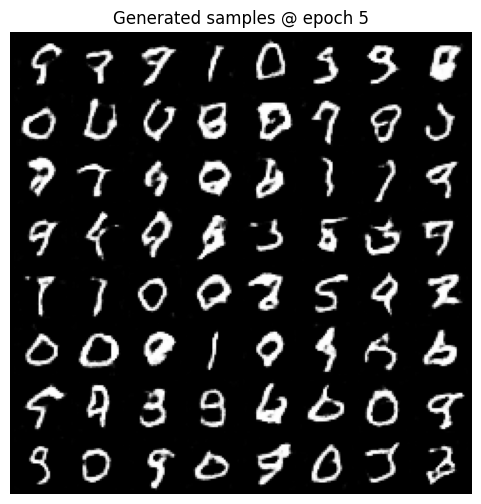

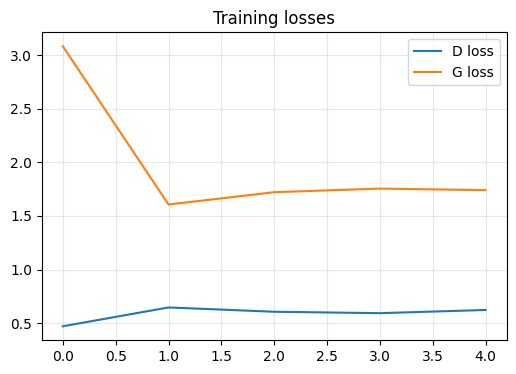

Epoch 6 [0/422] D=0.699 G=1.055
Epoch 6 [50/422] D=0.585 G=1.667
Epoch 6 [100/422] D=0.577 G=1.263
Epoch 6 [150/422] D=0.547 G=1.764
Epoch 6 [200/422] D=0.639 G=2.202
Epoch 6 [250/422] D=0.595 G=1.905
Epoch 6 [300/422] D=0.730 G=2.295
Epoch 6 [350/422] D=0.630 G=1.447
Epoch 6 [400/422] D=0.696 G=1.857
==> Epoch 6: D=0.633 G=1.736 | diversity(std)=0.6138
Epoch 7 [0/422] D=0.563 G=1.222
Epoch 7 [50/422] D=0.832 G=0.826
Epoch 7 [100/422] D=0.504 G=1.758
Epoch 7 [150/422] D=0.685 G=1.667
Epoch 7 [200/422] D=0.608 G=1.918
Epoch 7 [250/422] D=0.470 G=1.733
Epoch 7 [300/422] D=0.614 G=1.259
Epoch 7 [350/422] D=0.641 G=1.115
Epoch 7 [400/422] D=0.676 G=0.940
==> Epoch 7: D=0.637 G=1.746 | diversity(std)=0.6026
Epoch 8 [0/422] D=0.843 G=2.860
Epoch 8 [50/422] D=0.579 G=2.212
Epoch 8 [100/422] D=0.601 G=1.897
Epoch 8 [150/422] D=0.707 G=2.145
Epoch 8 [200/422] D=0.511 G=1.586
Epoch 8 [250/422] D=0.492 G=2.114
Epoch 8 [300/422] D=0.515 G=1.329
Epoch 8 [350/422] D=0.855 G=0.653
Epoch 8 [400/422] D

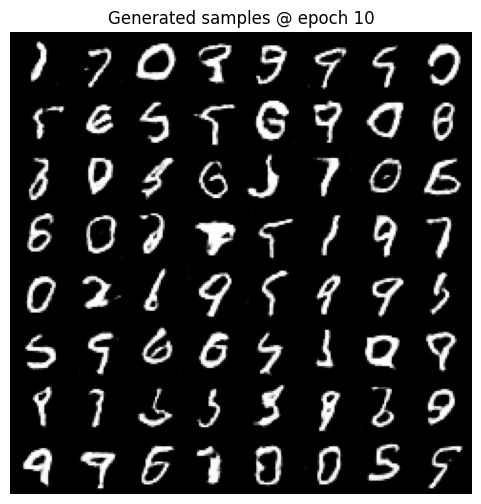

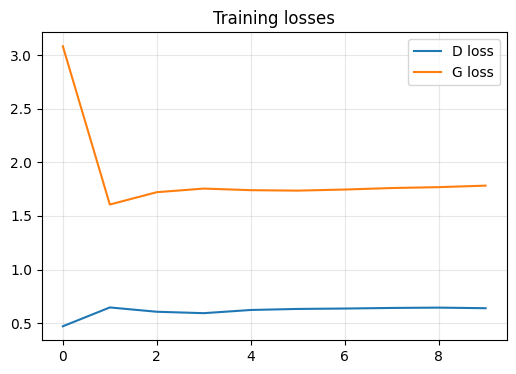

Epoch 11 [0/422] D=0.496 G=1.524
Epoch 11 [50/422] D=0.598 G=2.734
Epoch 11 [100/422] D=0.595 G=1.539
Epoch 11 [150/422] D=0.631 G=1.764
Epoch 11 [200/422] D=0.590 G=2.223
Epoch 11 [250/422] D=0.767 G=0.890
Epoch 11 [300/422] D=0.665 G=1.265
Epoch 11 [350/422] D=0.636 G=2.363
Epoch 11 [400/422] D=0.668 G=1.277
==> Epoch 11: D=0.643 G=1.810 | diversity(std)=0.6208
Epoch 12 [0/422] D=0.585 G=2.090
Epoch 12 [50/422] D=0.722 G=1.337
Epoch 12 [100/422] D=0.787 G=2.763
Epoch 12 [150/422] D=0.706 G=0.920
Epoch 12 [200/422] D=0.552 G=1.411
Epoch 12 [250/422] D=0.595 G=1.463
Epoch 12 [300/422] D=0.505 G=2.265
Epoch 12 [350/422] D=0.628 G=1.564
Epoch 12 [400/422] D=0.531 G=2.019
==> Epoch 12: D=0.671 G=1.790 | diversity(std)=0.6166
Epoch 13 [0/422] D=0.497 G=1.914
Epoch 13 [50/422] D=0.639 G=2.257
Epoch 13 [100/422] D=0.535 G=2.433
Epoch 13 [150/422] D=0.576 G=1.601
Epoch 13 [200/422] D=0.537 G=1.757
Epoch 13 [250/422] D=0.769 G=0.865
Epoch 13 [300/422] D=0.643 G=1.612
Epoch 13 [350/422] D=0.603

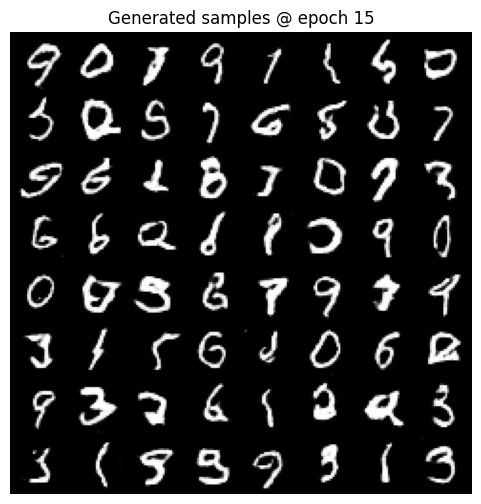

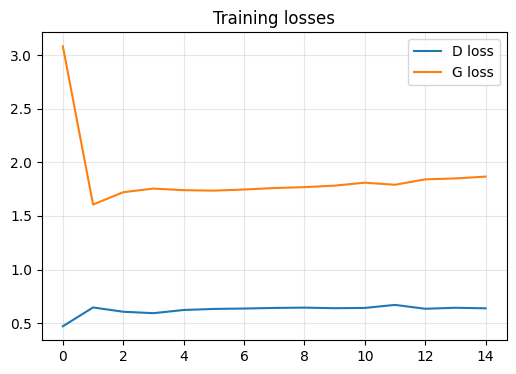

Epoch 16 [0/422] D=0.632 G=1.978
Epoch 16 [50/422] D=0.610 G=1.926
Epoch 16 [100/422] D=0.637 G=1.895
Epoch 16 [150/422] D=0.522 G=1.313
Epoch 16 [200/422] D=0.619 G=1.749
Epoch 16 [250/422] D=0.527 G=1.616
Epoch 16 [300/422] D=0.571 G=1.678
Epoch 16 [350/422] D=0.566 G=1.994
Epoch 16 [400/422] D=0.687 G=1.892
==> Epoch 16: D=0.617 G=1.902 | diversity(std)=0.6315
Epoch 17 [0/422] D=0.780 G=1.020
Epoch 17 [50/422] D=0.737 G=2.418
Epoch 17 [100/422] D=0.544 G=0.981
Epoch 17 [150/422] D=0.542 G=1.788
Epoch 17 [200/422] D=0.652 G=2.117
Epoch 17 [250/422] D=0.583 G=1.705
Epoch 17 [300/422] D=0.572 G=2.097
Epoch 17 [350/422] D=0.622 G=2.440
Epoch 17 [400/422] D=0.687 G=2.675
==> Epoch 17: D=0.623 G=1.912 | diversity(std)=0.6003
Epoch 18 [0/422] D=0.549 G=2.153
Epoch 18 [50/422] D=0.612 G=1.266
Epoch 18 [100/422] D=0.686 G=0.895
Epoch 18 [150/422] D=0.521 G=2.791
Epoch 18 [200/422] D=0.508 G=2.183
Epoch 18 [250/422] D=0.557 G=2.362
Epoch 18 [300/422] D=0.574 G=2.169
Epoch 18 [350/422] D=0.592

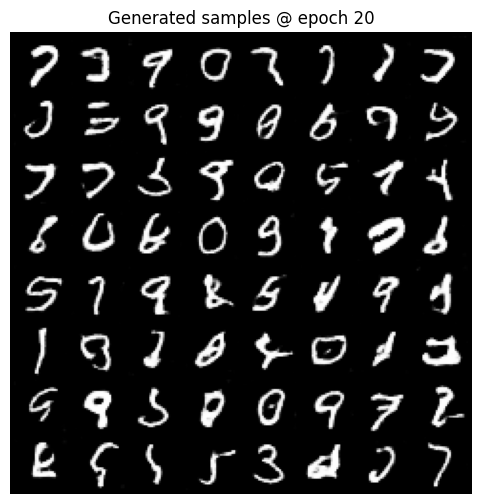

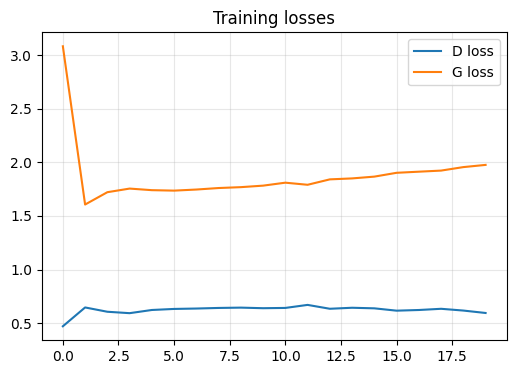

Epoch 21 [0/422] D=0.415 G=2.331
Epoch 21 [50/422] D=0.464 G=2.262
Epoch 21 [100/422] D=0.526 G=1.924
Epoch 21 [150/422] D=0.818 G=1.269
Epoch 21 [200/422] D=0.794 G=1.917
Epoch 21 [250/422] D=0.592 G=2.169
Epoch 21 [300/422] D=0.530 G=2.417
Epoch 21 [350/422] D=0.492 G=2.259
Epoch 21 [400/422] D=0.534 G=1.649
==> Epoch 21: D=0.605 G=1.985 | diversity(std)=0.6033
Epoch 22 [0/422] D=0.622 G=2.551
Epoch 22 [50/422] D=0.661 G=2.643
Epoch 22 [100/422] D=0.421 G=1.740
Epoch 22 [150/422] D=0.603 G=1.912
Epoch 22 [200/422] D=0.690 G=2.259
Epoch 22 [250/422] D=0.438 G=1.857
Epoch 22 [300/422] D=0.554 G=1.582
Epoch 22 [350/422] D=0.446 G=1.968
Epoch 22 [400/422] D=0.474 G=1.629
==> Epoch 22: D=0.612 G=2.001 | diversity(std)=0.6289
Epoch 23 [0/422] D=1.216 G=3.716
Epoch 23 [50/422] D=0.641 G=2.030
Epoch 23 [100/422] D=0.569 G=1.519
Epoch 23 [150/422] D=0.616 G=2.315
Epoch 23 [200/422] D=0.558 G=1.626
Epoch 23 [250/422] D=0.651 G=2.852
Epoch 23 [300/422] D=0.644 G=1.379
Epoch 23 [350/422] D=0.492

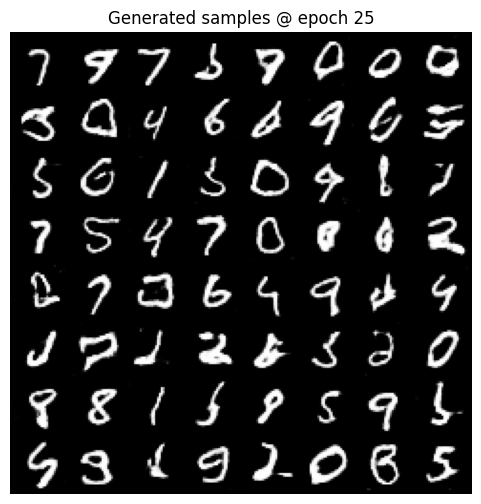

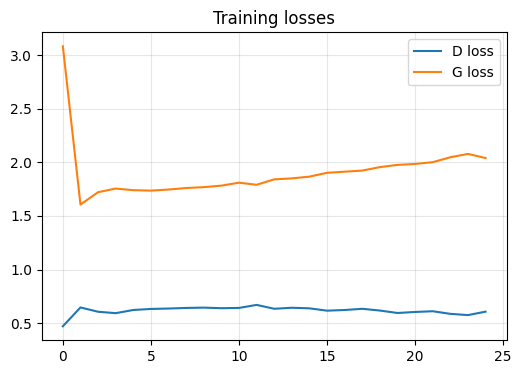

Epoch 26 [0/422] D=0.690 G=1.219
Epoch 26 [50/422] D=0.590 G=1.319
Epoch 26 [100/422] D=0.614 G=1.810
Epoch 26 [150/422] D=0.601 G=2.111
Epoch 26 [200/422] D=0.571 G=1.568
Epoch 26 [250/422] D=0.551 G=1.551
Epoch 26 [300/422] D=0.522 G=2.032
Epoch 26 [350/422] D=0.538 G=1.589
Epoch 26 [400/422] D=0.467 G=2.103
==> Epoch 26: D=0.568 G=2.096 | diversity(std)=0.6168
Epoch 27 [0/422] D=0.720 G=2.800
Epoch 27 [50/422] D=0.508 G=2.877
Epoch 27 [100/422] D=0.423 G=2.047
Epoch 27 [150/422] D=0.511 G=2.218
Epoch 27 [200/422] D=1.247 G=4.516
Epoch 27 [250/422] D=0.518 G=2.026
Epoch 27 [300/422] D=0.646 G=1.238
Epoch 27 [350/422] D=0.567 G=2.552
Epoch 27 [400/422] D=0.423 G=2.193
==> Epoch 27: D=0.570 G=2.116 | diversity(std)=0.6313
Epoch 28 [0/422] D=0.490 G=2.272
Epoch 28 [50/422] D=0.539 G=2.014
Epoch 28 [100/422] D=0.441 G=2.067
Epoch 28 [150/422] D=0.563 G=2.499
Epoch 28 [200/422] D=0.613 G=1.778
Epoch 28 [250/422] D=0.470 G=2.439
Epoch 28 [300/422] D=0.666 G=2.190
Epoch 28 [350/422] D=1.363

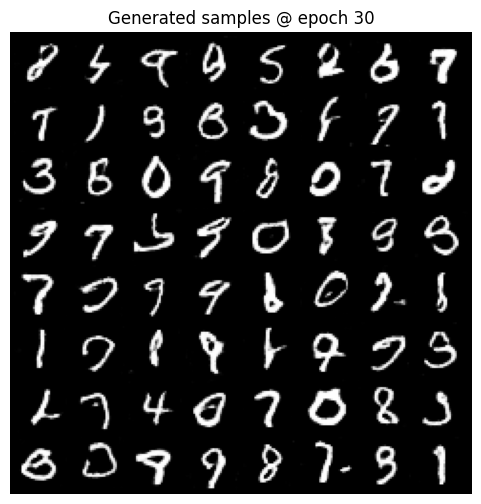

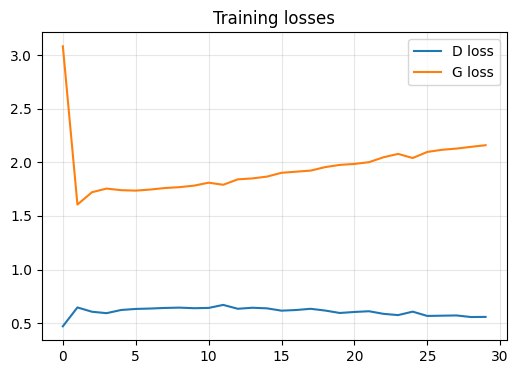

Epoch 31 [0/422] D=0.443 G=1.772
Epoch 31 [50/422] D=0.456 G=1.786
Epoch 31 [100/422] D=0.441 G=2.127
Epoch 31 [150/422] D=0.786 G=3.637
Epoch 31 [200/422] D=0.463 G=2.796
Epoch 31 [250/422] D=0.386 G=3.712
Epoch 31 [300/422] D=0.581 G=2.362
Epoch 31 [350/422] D=0.525 G=2.880
Epoch 31 [400/422] D=0.831 G=3.497
==> Epoch 31: D=0.545 G=2.185 | diversity(std)=0.6125
Epoch 32 [0/422] D=0.458 G=2.480
Epoch 32 [50/422] D=0.500 G=2.224
Epoch 32 [100/422] D=0.615 G=2.392
Epoch 32 [150/422] D=1.036 G=3.991
Epoch 32 [200/422] D=0.630 G=1.228
Epoch 32 [250/422] D=0.693 G=3.158
Epoch 32 [300/422] D=0.421 G=2.041
Epoch 32 [350/422] D=0.550 G=2.153
Epoch 32 [400/422] D=0.649 G=1.693
==> Epoch 32: D=0.554 G=2.198 | diversity(std)=0.6305
Epoch 33 [0/422] D=0.631 G=3.213
Epoch 33 [50/422] D=0.552 G=1.912
Epoch 33 [100/422] D=0.497 G=2.370
Epoch 33 [150/422] D=0.912 G=3.617
Epoch 33 [200/422] D=0.575 G=1.773
Epoch 33 [250/422] D=0.529 G=2.622
Epoch 33 [300/422] D=0.485 G=2.507
Epoch 33 [350/422] D=0.413

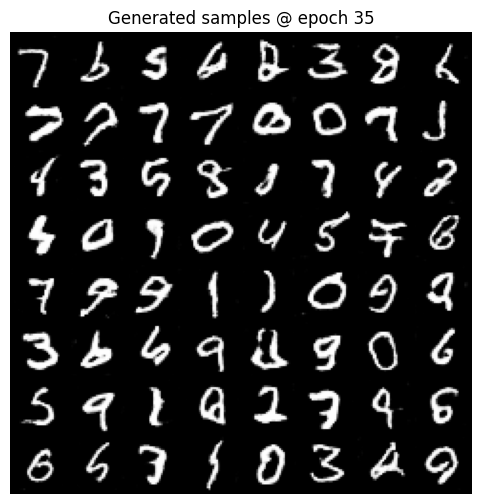

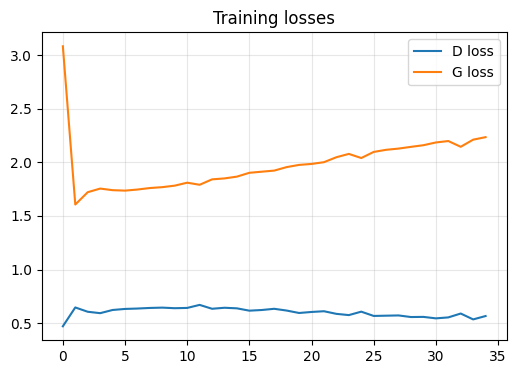

Epoch 36 [0/422] D=0.436 G=2.616
Epoch 36 [50/422] D=0.663 G=2.606
Epoch 36 [100/422] D=0.469 G=1.306
Epoch 36 [150/422] D=0.416 G=2.370
Epoch 36 [200/422] D=0.649 G=1.565
Epoch 36 [250/422] D=0.608 G=3.058
Epoch 36 [300/422] D=0.642 G=2.989
Epoch 36 [350/422] D=0.542 G=3.431
Epoch 36 [400/422] D=0.600 G=1.592
==> Epoch 36: D=0.535 G=2.229 | diversity(std)=0.6144
Epoch 37 [0/422] D=0.499 G=2.820
Epoch 37 [50/422] D=0.666 G=2.984
Epoch 37 [100/422] D=0.482 G=2.813
Epoch 37 [150/422] D=0.747 G=2.936
Epoch 37 [200/422] D=0.707 G=1.819
Epoch 37 [250/422] D=0.495 G=3.144
Epoch 37 [300/422] D=0.532 G=2.023
Epoch 37 [350/422] D=0.513 G=2.147
Epoch 37 [400/422] D=0.537 G=2.081
==> Epoch 37: D=0.529 G=2.252 | diversity(std)=0.6215
Epoch 38 [0/422] D=0.430 G=2.315
Epoch 38 [50/422] D=0.529 G=1.141
Epoch 38 [100/422] D=0.463 G=2.486
Epoch 38 [150/422] D=0.435 G=2.371
Epoch 38 [200/422] D=1.145 G=0.462
Epoch 38 [250/422] D=0.517 G=1.850
Epoch 38 [300/422] D=0.632 G=1.709
Epoch 38 [350/422] D=0.614

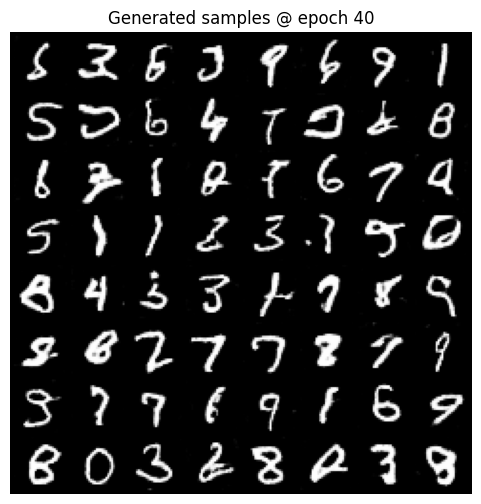

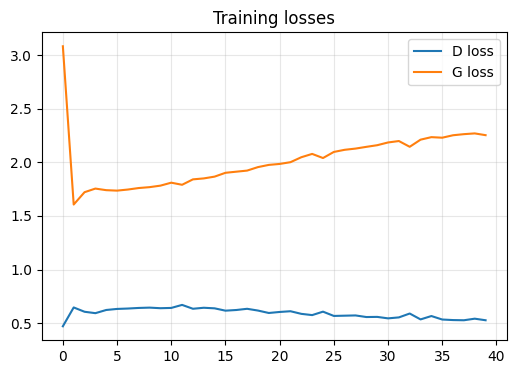

Epoch 41 [0/422] D=0.498 G=1.800
Epoch 41 [50/422] D=0.511 G=1.563
Epoch 41 [100/422] D=0.406 G=2.358
Epoch 41 [150/422] D=0.357 G=2.618
Epoch 41 [200/422] D=0.367 G=2.615
Epoch 41 [250/422] D=0.485 G=3.260
Epoch 41 [300/422] D=0.860 G=3.755
Epoch 41 [350/422] D=0.334 G=2.509
Epoch 41 [400/422] D=0.507 G=1.574
==> Epoch 41: D=0.521 G=2.302 | diversity(std)=0.6239
Epoch 42 [0/422] D=0.549 G=2.190
Epoch 42 [50/422] D=0.539 G=1.649
Epoch 42 [100/422] D=0.438 G=1.831
Epoch 42 [150/422] D=0.527 G=1.423
Epoch 42 [200/422] D=0.537 G=1.271
Epoch 42 [250/422] D=0.302 G=2.306
Epoch 42 [300/422] D=0.687 G=2.639
Epoch 42 [350/422] D=0.660 G=1.987
Epoch 42 [400/422] D=0.438 G=1.353
==> Epoch 42: D=0.561 G=2.254 | diversity(std)=0.6227
Epoch 43 [0/422] D=0.643 G=3.024
Epoch 43 [50/422] D=0.493 G=2.048
Epoch 43 [100/422] D=0.731 G=2.729
Epoch 43 [150/422] D=0.418 G=2.120
Epoch 43 [200/422] D=0.528 G=2.614
Epoch 43 [250/422] D=0.451 G=2.226
Epoch 43 [300/422] D=0.373 G=2.260
Epoch 43 [350/422] D=0.558

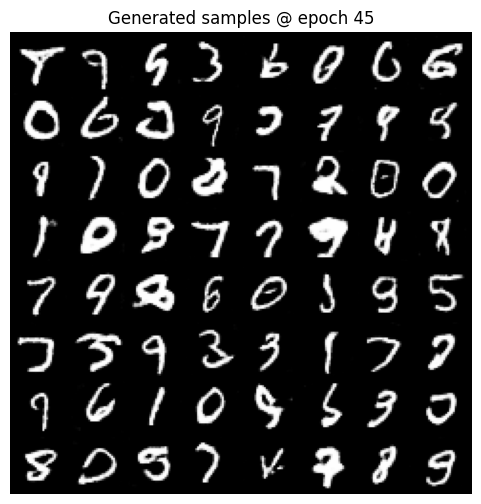

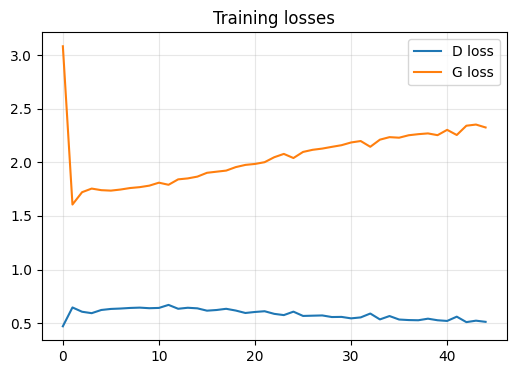

Epoch 46 [0/422] D=0.482 G=1.885
Epoch 46 [50/422] D=0.612 G=3.355
Epoch 46 [100/422] D=0.721 G=1.397
Epoch 46 [150/422] D=0.376 G=2.118
Epoch 46 [200/422] D=0.380 G=2.068
Epoch 46 [250/422] D=0.447 G=2.664
Epoch 46 [300/422] D=0.408 G=2.107
Epoch 46 [350/422] D=0.471 G=1.876
Epoch 46 [400/422] D=0.930 G=3.696
==> Epoch 46: D=0.496 G=2.361 | diversity(std)=0.6108
Epoch 47 [0/422] D=0.602 G=1.458
Epoch 47 [50/422] D=0.402 G=1.917
Epoch 47 [100/422] D=0.450 G=3.508
Epoch 47 [150/422] D=0.369 G=2.730
Epoch 47 [200/422] D=0.714 G=1.086
Epoch 47 [250/422] D=0.358 G=2.629
Epoch 47 [300/422] D=0.505 G=1.489
Epoch 47 [350/422] D=0.438 G=3.027
Epoch 47 [400/422] D=0.407 G=1.576
==> Epoch 47: D=0.528 G=2.316 | diversity(std)=0.6165
Epoch 48 [0/422] D=0.358 G=2.023
Epoch 48 [50/422] D=0.413 G=2.669
Epoch 48 [100/422] D=0.470 G=1.924
Epoch 48 [150/422] D=0.401 G=3.261
Epoch 48 [200/422] D=0.450 G=2.614
Epoch 48 [250/422] D=0.312 G=2.663
Epoch 48 [300/422] D=0.350 G=2.278
Epoch 48 [350/422] D=0.509

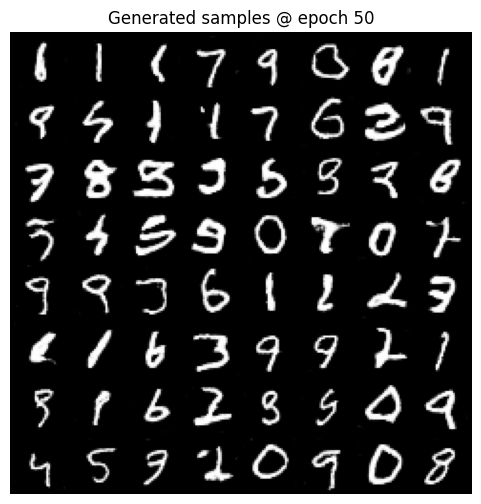

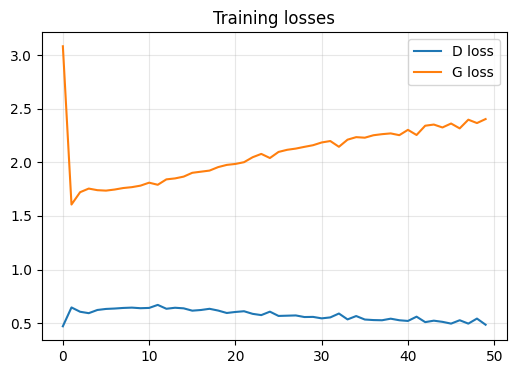

Epoch 51 [0/422] D=1.328 G=5.161
Epoch 51 [50/422] D=0.511 G=1.604
Epoch 51 [100/422] D=0.433 G=2.348
Epoch 51 [150/422] D=0.441 G=3.152
Epoch 51 [200/422] D=0.474 G=2.746
Epoch 51 [250/422] D=0.415 G=2.245
Epoch 51 [300/422] D=0.505 G=1.508
Epoch 51 [350/422] D=0.566 G=2.648
Epoch 51 [400/422] D=0.754 G=0.519
==> Epoch 51: D=0.484 G=2.440 | diversity(std)=0.6159
Epoch 52 [0/422] D=0.565 G=2.223
Epoch 52 [50/422] D=0.787 G=4.440
Epoch 52 [100/422] D=0.558 G=3.487
Epoch 52 [150/422] D=0.428 G=3.564
Epoch 52 [200/422] D=0.363 G=2.023
Epoch 52 [250/422] D=0.414 G=1.638
Epoch 52 [300/422] D=0.614 G=1.812
Epoch 52 [350/422] D=0.411 G=2.254
Epoch 52 [400/422] D=0.359 G=1.917
==> Epoch 52: D=0.506 G=2.428 | diversity(std)=0.6093
Epoch 53 [0/422] D=0.381 G=2.588
Epoch 53 [50/422] D=0.393 G=2.680
Epoch 53 [100/422] D=0.451 G=2.863
Epoch 53 [150/422] D=0.732 G=3.574
Epoch 53 [200/422] D=0.532 G=1.612
Epoch 53 [250/422] D=0.368 G=3.160
Epoch 53 [300/422] D=1.052 G=3.951
Epoch 53 [350/422] D=0.386

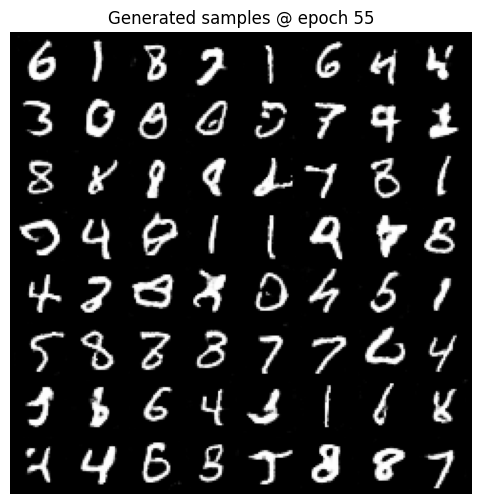

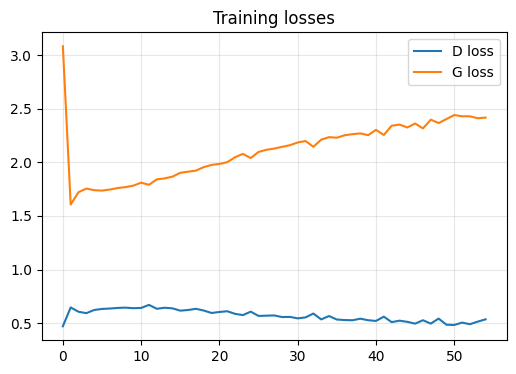

Epoch 56 [0/422] D=0.534 G=3.856
Epoch 56 [50/422] D=0.643 G=0.751
Epoch 56 [100/422] D=0.549 G=3.062
Epoch 56 [150/422] D=0.555 G=2.108
Epoch 56 [200/422] D=0.458 G=1.803
Epoch 56 [250/422] D=0.836 G=1.578
Epoch 56 [300/422] D=0.421 G=2.379
Epoch 56 [350/422] D=0.557 G=1.800
Epoch 56 [400/422] D=0.393 G=2.204
==> Epoch 56: D=0.474 G=2.449 | diversity(std)=0.6140
Epoch 57 [0/422] D=0.379 G=3.243
Epoch 57 [50/422] D=0.432 G=3.068
Epoch 57 [100/422] D=0.478 G=2.109
Epoch 57 [150/422] D=0.447 G=2.099
Epoch 57 [200/422] D=0.438 G=1.764
Epoch 57 [250/422] D=0.414 G=3.234
Epoch 57 [300/422] D=0.587 G=2.758
Epoch 57 [350/422] D=0.408 G=2.050
Epoch 57 [400/422] D=0.629 G=1.172
==> Epoch 57: D=0.497 G=2.480 | diversity(std)=0.6199
Epoch 58 [0/422] D=0.324 G=2.974
Epoch 58 [50/422] D=0.379 G=2.531
Epoch 58 [100/422] D=0.283 G=3.202
Epoch 58 [150/422] D=0.287 G=2.614
Epoch 58 [200/422] D=0.530 G=3.562
Epoch 58 [250/422] D=0.736 G=1.328
Epoch 58 [300/422] D=0.587 G=3.596
Epoch 58 [350/422] D=0.485

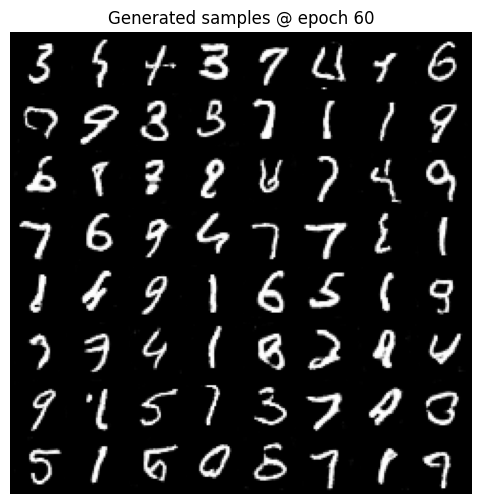

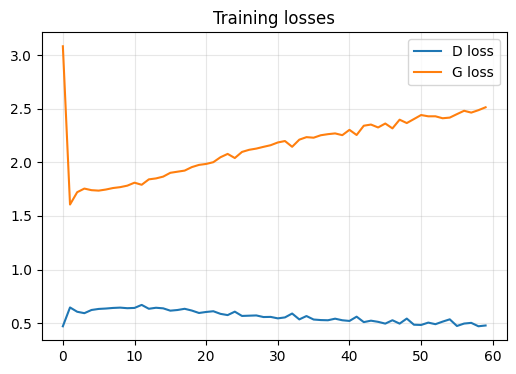

Epoch 61 [0/422] D=0.375 G=2.170
Epoch 61 [50/422] D=0.500 G=3.407
Epoch 61 [100/422] D=0.538 G=1.849
Epoch 61 [150/422] D=0.476 G=2.010
Epoch 61 [200/422] D=0.416 G=3.917
Epoch 61 [250/422] D=0.662 G=0.854
Epoch 61 [300/422] D=0.583 G=2.225
Epoch 61 [350/422] D=0.600 G=4.099
Epoch 61 [400/422] D=0.461 G=1.450
==> Epoch 61: D=0.471 G=2.539 | diversity(std)=0.6170
Epoch 62 [0/422] D=0.685 G=2.423
Epoch 62 [50/422] D=0.585 G=3.739
Epoch 62 [100/422] D=0.333 G=2.866
Epoch 62 [150/422] D=0.545 G=1.895
Epoch 62 [200/422] D=0.401 G=2.425
Epoch 62 [250/422] D=0.397 G=3.206
Epoch 62 [300/422] D=0.458 G=1.841
Epoch 62 [350/422] D=0.454 G=2.736
Epoch 62 [400/422] D=0.475 G=1.661
==> Epoch 62: D=0.502 G=2.499 | diversity(std)=0.6287
Epoch 63 [0/422] D=0.309 G=3.024
Epoch 63 [50/422] D=0.496 G=2.748
Epoch 63 [100/422] D=2.441 G=0.128
Epoch 63 [150/422] D=0.445 G=2.376
Epoch 63 [200/422] D=0.478 G=1.952
Epoch 63 [250/422] D=0.376 G=2.702
Epoch 63 [300/422] D=0.491 G=2.403
Epoch 63 [350/422] D=0.391

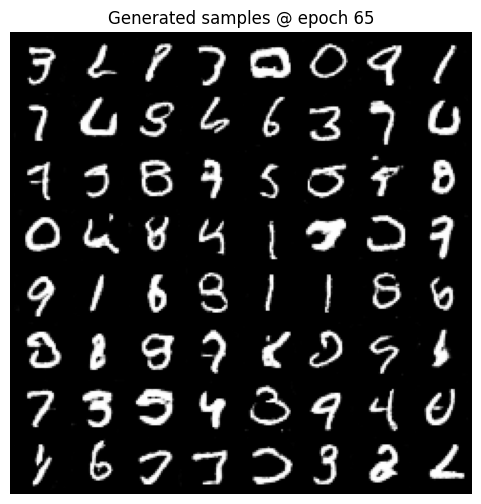

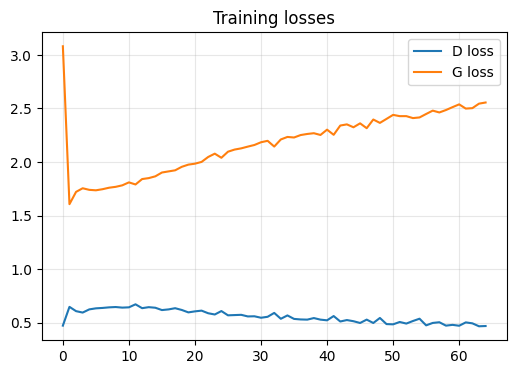

Epoch 66 [0/422] D=0.523 G=2.659
Epoch 66 [50/422] D=0.556 G=2.623
Epoch 66 [100/422] D=0.365 G=2.496
Epoch 66 [150/422] D=0.340 G=2.359
Epoch 66 [200/422] D=0.292 G=2.635
Epoch 66 [250/422] D=0.403 G=2.591
Epoch 66 [300/422] D=0.359 G=2.017
Epoch 66 [350/422] D=0.407 G=3.088
Epoch 66 [400/422] D=0.507 G=0.874
==> Epoch 66: D=0.491 G=2.538 | diversity(std)=0.6129
Epoch 67 [0/422] D=0.431 G=2.514
Epoch 67 [50/422] D=0.438 G=2.409
Epoch 67 [100/422] D=0.552 G=2.139
Epoch 67 [150/422] D=0.378 G=2.473
Epoch 67 [200/422] D=0.467 G=2.524
Epoch 67 [250/422] D=0.620 G=3.169
Epoch 67 [300/422] D=0.464 G=1.986
Epoch 67 [350/422] D=0.386 G=2.712
Epoch 67 [400/422] D=0.399 G=1.750
==> Epoch 67: D=0.464 G=2.539 | diversity(std)=0.6285
Epoch 68 [0/422] D=0.404 G=2.528
Epoch 68 [50/422] D=0.513 G=2.969
Epoch 68 [100/422] D=0.257 G=2.521
Epoch 68 [150/422] D=0.366 G=2.207
Epoch 68 [200/422] D=0.468 G=2.022
Epoch 68 [250/422] D=0.394 G=3.279
Epoch 68 [300/422] D=0.715 G=1.958
Epoch 68 [350/422] D=0.419

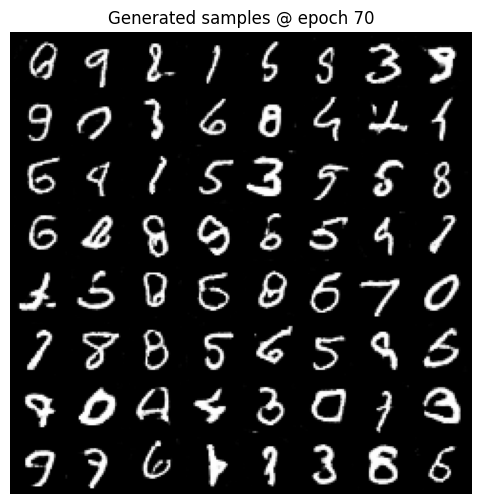

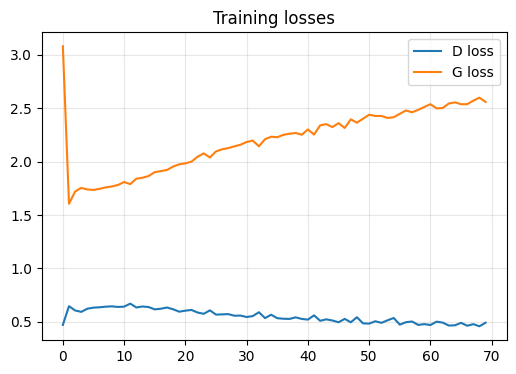

Epoch 71 [0/422] D=1.102 G=1.467
Epoch 71 [50/422] D=0.367 G=2.897
Epoch 71 [100/422] D=0.650 G=1.207
Epoch 71 [150/422] D=1.045 G=3.718
Epoch 71 [200/422] D=0.628 G=1.798
Epoch 71 [250/422] D=0.323 G=2.638
Epoch 71 [300/422] D=0.923 G=0.661
Epoch 71 [350/422] D=0.558 G=1.803
Epoch 71 [400/422] D=0.320 G=2.270
==> Epoch 71: D=0.496 G=2.526 | diversity(std)=0.6081
Epoch 72 [0/422] D=0.420 G=2.845
Epoch 72 [50/422] D=0.450 G=3.219
Epoch 72 [100/422] D=0.353 G=2.043
Epoch 72 [150/422] D=0.439 G=2.734
Epoch 72 [200/422] D=0.333 G=2.809
Epoch 72 [250/422] D=0.345 G=1.998
Epoch 72 [300/422] D=0.445 G=1.849
Epoch 72 [350/422] D=0.333 G=2.786
Epoch 72 [400/422] D=0.487 G=2.717
==> Epoch 72: D=0.453 G=2.615 | diversity(std)=0.6195
Epoch 73 [0/422] D=0.463 G=3.109
Epoch 73 [50/422] D=0.378 G=2.667
Epoch 73 [100/422] D=0.466 G=2.747
Epoch 73 [150/422] D=0.586 G=2.523
Epoch 73 [200/422] D=0.422 G=4.042
Epoch 73 [250/422] D=0.373 G=1.789
Epoch 73 [300/422] D=0.291 G=2.561
Epoch 73 [350/422] D=0.449

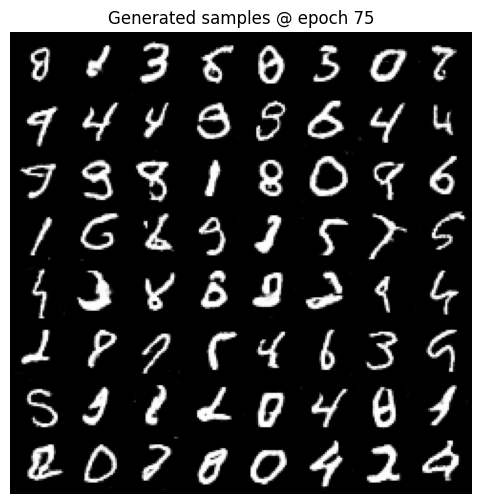

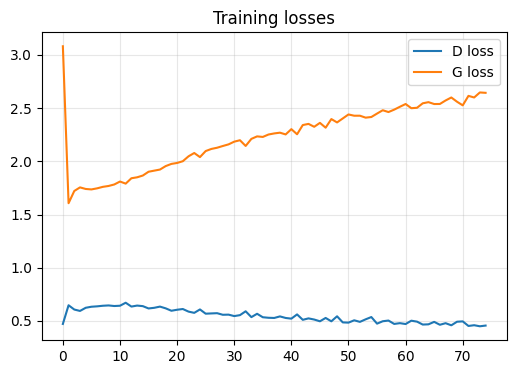

Epoch 76 [0/422] D=0.335 G=2.771
Epoch 76 [50/422] D=0.345 G=2.783
Epoch 76 [100/422] D=0.594 G=4.319
Epoch 76 [150/422] D=0.404 G=3.318
Epoch 76 [200/422] D=0.421 G=3.011
Epoch 76 [250/422] D=0.350 G=2.382
Epoch 76 [300/422] D=0.304 G=2.574
Epoch 76 [350/422] D=0.421 G=4.628
Epoch 76 [400/422] D=0.580 G=2.748
==> Epoch 76: D=0.495 G=2.601 | diversity(std)=0.6177
Epoch 77 [0/422] D=0.542 G=1.292
Epoch 77 [50/422] D=0.433 G=2.480
Epoch 77 [100/422] D=0.466 G=1.394
Epoch 77 [150/422] D=0.323 G=2.321
Epoch 77 [200/422] D=0.300 G=2.708
Epoch 77 [250/422] D=0.506 G=3.543
Epoch 77 [300/422] D=0.516 G=1.296
Epoch 77 [350/422] D=0.675 G=2.098
Epoch 77 [400/422] D=0.551 G=3.433
==> Epoch 77: D=0.478 G=2.648 | diversity(std)=0.6225
Epoch 78 [0/422] D=0.406 G=2.670
Epoch 78 [50/422] D=0.435 G=2.184
Epoch 78 [100/422] D=0.341 G=1.994
Epoch 78 [150/422] D=0.348 G=2.143
Epoch 78 [200/422] D=0.481 G=2.816
Epoch 78 [250/422] D=0.384 G=2.571
Epoch 78 [300/422] D=0.484 G=1.405
Epoch 78 [350/422] D=0.335

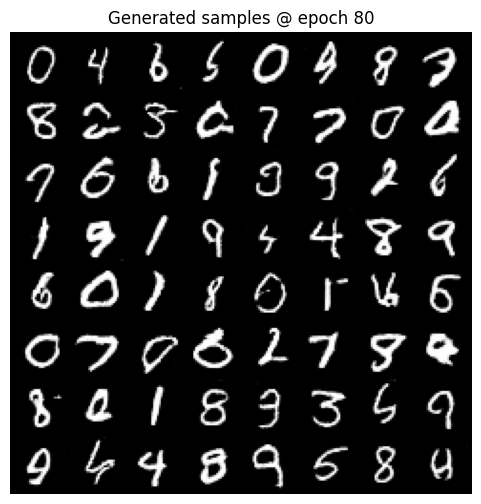

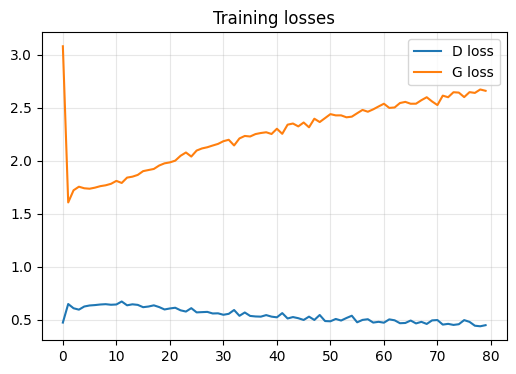

Epoch 81 [0/422] D=0.982 G=0.638
Epoch 81 [50/422] D=0.389 G=2.064
Epoch 81 [100/422] D=0.353 G=2.646
Epoch 81 [150/422] D=0.362 G=2.517
Epoch 81 [200/422] D=0.710 G=4.362
Epoch 81 [250/422] D=0.413 G=2.066
Epoch 81 [300/422] D=0.427 G=1.529
Epoch 81 [350/422] D=0.620 G=3.763
Epoch 81 [400/422] D=0.360 G=2.490
==> Epoch 81: D=0.522 G=2.601 | diversity(std)=0.6118
Epoch 82 [0/422] D=0.534 G=1.469
Epoch 82 [50/422] D=0.406 G=3.250
Epoch 82 [100/422] D=0.426 G=2.505
Epoch 82 [150/422] D=0.302 G=3.125
Epoch 82 [200/422] D=0.371 G=2.433
Epoch 82 [250/422] D=0.540 G=3.652
Epoch 82 [300/422] D=0.364 G=2.831
Epoch 82 [350/422] D=0.372 G=1.819
Epoch 82 [400/422] D=0.817 G=4.465
==> Epoch 82: D=0.435 G=2.698 | diversity(std)=0.6111
Epoch 83 [0/422] D=0.377 G=2.433
Epoch 83 [50/422] D=0.479 G=1.837
Epoch 83 [100/422] D=0.330 G=3.977
Epoch 83 [150/422] D=0.450 G=3.964
Epoch 83 [200/422] D=0.363 G=2.331
Epoch 83 [250/422] D=0.367 G=2.820
Epoch 83 [300/422] D=0.370 G=1.382
Epoch 83 [350/422] D=0.382

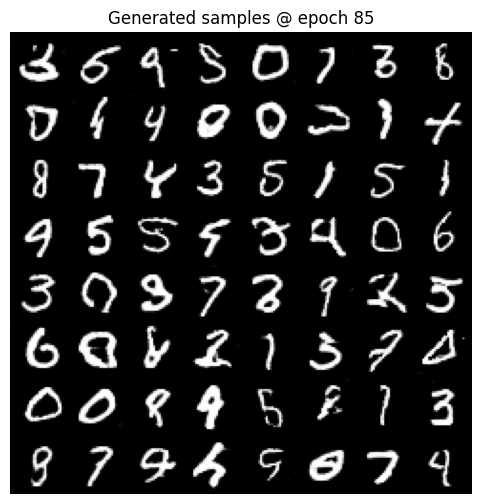

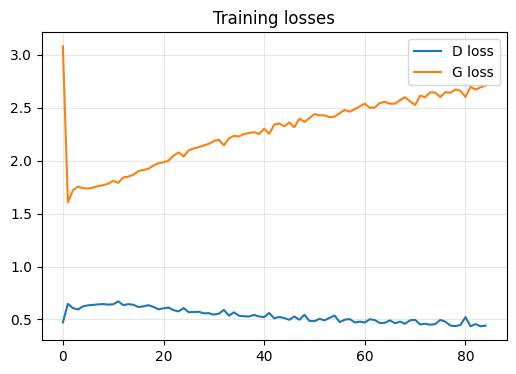

Epoch 86 [0/422] D=0.363 G=2.102
Epoch 86 [50/422] D=0.339 G=2.499
Epoch 86 [100/422] D=0.504 G=3.944
Epoch 86 [150/422] D=0.344 G=2.935
Epoch 86 [200/422] D=0.301 G=2.060
Epoch 86 [250/422] D=0.507 G=3.847
Epoch 86 [300/422] D=0.342 G=3.233
Epoch 86 [350/422] D=0.464 G=1.600
Epoch 86 [400/422] D=0.361 G=2.312
==> Epoch 86: D=0.445 G=2.736 | diversity(std)=0.6138
Epoch 87 [0/422] D=0.442 G=2.692
Epoch 87 [50/422] D=0.326 G=3.107
Epoch 87 [100/422] D=0.377 G=2.803
Epoch 87 [150/422] D=0.409 G=3.516
Epoch 87 [200/422] D=0.484 G=3.454
Epoch 87 [250/422] D=0.691 G=3.292
Epoch 87 [300/422] D=0.439 G=2.265
Epoch 87 [350/422] D=0.582 G=4.009
Epoch 87 [400/422] D=0.407 G=2.209
==> Epoch 87: D=0.428 G=2.744 | diversity(std)=0.6216
Epoch 88 [0/422] D=0.371 G=4.302
Epoch 88 [50/422] D=1.433 G=1.333
Epoch 88 [100/422] D=0.456 G=2.441
Epoch 88 [150/422] D=0.415 G=2.994
Epoch 88 [200/422] D=0.440 G=2.473
Epoch 88 [250/422] D=0.370 G=2.060
Epoch 88 [300/422] D=0.369 G=2.403
Epoch 88 [350/422] D=0.307

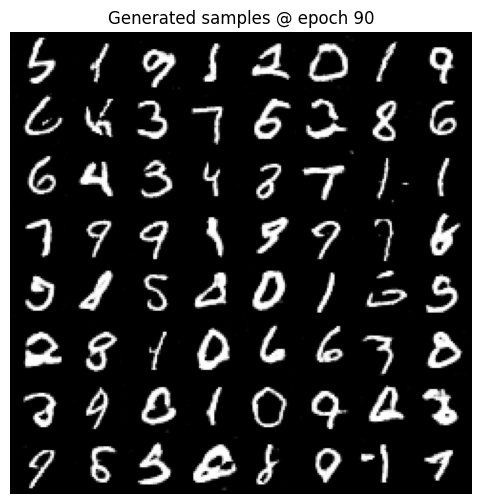

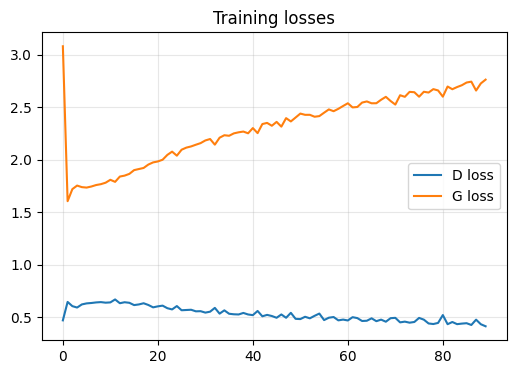

Epoch 91 [0/422] D=0.291 G=2.410
Epoch 91 [50/422] D=0.427 G=3.010
Epoch 91 [100/422] D=0.328 G=2.552
Epoch 91 [150/422] D=0.409 G=3.339
Epoch 91 [200/422] D=0.425 G=2.102
Epoch 91 [250/422] D=0.494 G=2.701
Epoch 91 [300/422] D=0.477 G=2.155
Epoch 91 [350/422] D=0.460 G=2.447
Epoch 91 [400/422] D=0.477 G=2.799
==> Epoch 91: D=0.445 G=2.755 | diversity(std)=0.6031
Epoch 92 [0/422] D=0.363 G=2.962
Epoch 92 [50/422] D=0.342 G=2.489
Epoch 92 [100/422] D=0.330 G=2.878
Epoch 92 [150/422] D=0.559 G=1.741
Epoch 92 [200/422] D=0.513 G=2.473
Epoch 92 [250/422] D=0.414 G=2.628
Epoch 92 [300/422] D=0.506 G=3.467
Epoch 92 [350/422] D=0.806 G=3.521
Epoch 92 [400/422] D=0.391 G=3.342
==> Epoch 92: D=0.433 G=2.774 | diversity(std)=0.6027
Epoch 93 [0/422] D=0.414 G=2.264
Epoch 93 [50/422] D=0.355 G=2.938
Epoch 93 [100/422] D=0.413 G=1.971
Epoch 93 [150/422] D=0.411 G=2.168
Epoch 93 [200/422] D=0.313 G=3.423
Epoch 93 [250/422] D=0.419 G=1.442
Epoch 93 [300/422] D=0.451 G=2.396
Epoch 93 [350/422] D=0.359

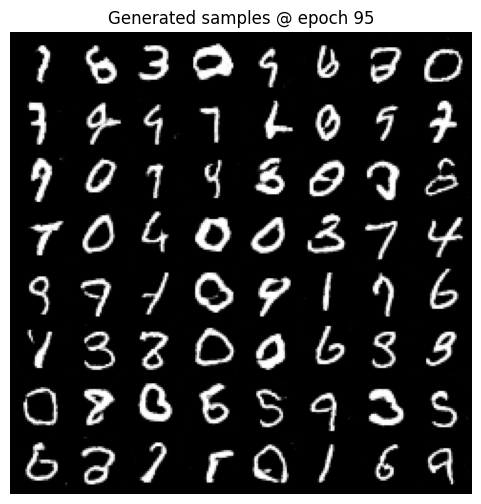

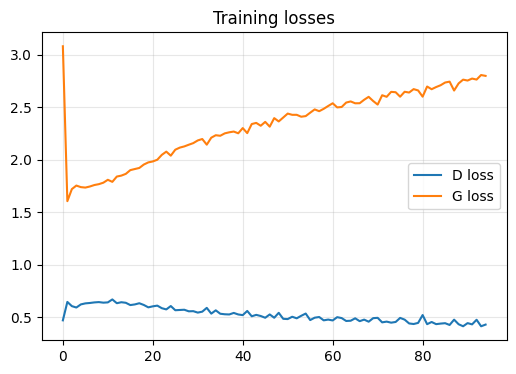

Epoch 96 [0/422] D=0.358 G=2.560
Epoch 96 [50/422] D=0.308 G=2.757
Epoch 96 [100/422] D=0.302 G=3.287
Epoch 96 [150/422] D=0.501 G=3.002
Epoch 96 [200/422] D=0.279 G=2.175
Epoch 96 [250/422] D=0.485 G=1.187
Epoch 96 [300/422] D=0.444 G=3.336
Epoch 96 [350/422] D=0.447 G=1.670
Epoch 96 [400/422] D=0.450 G=2.469
==> Epoch 96: D=0.424 G=2.828 | diversity(std)=0.6214
Epoch 97 [0/422] D=0.340 G=2.557
Epoch 97 [50/422] D=0.294 G=2.644
Epoch 97 [100/422] D=0.335 G=2.481
Epoch 97 [150/422] D=0.406 G=2.401
Epoch 97 [200/422] D=0.469 G=3.443
Epoch 97 [250/422] D=0.312 G=3.194
Epoch 97 [300/422] D=0.695 G=1.550
Epoch 97 [350/422] D=0.431 G=2.443
Epoch 97 [400/422] D=0.327 G=3.337
==> Epoch 97: D=0.424 G=2.830 | diversity(std)=0.6032
Epoch 98 [0/422] D=0.335 G=2.987
Epoch 98 [50/422] D=0.503 G=1.633
Epoch 98 [100/422] D=0.444 G=1.832
Epoch 98 [150/422] D=0.606 G=1.512
Epoch 98 [200/422] D=0.658 G=2.348
Epoch 98 [250/422] D=0.669 G=1.608
Epoch 98 [300/422] D=0.426 G=1.829
Epoch 98 [350/422] D=0.502

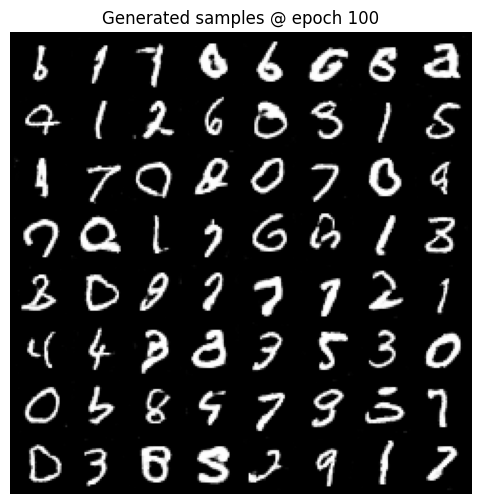

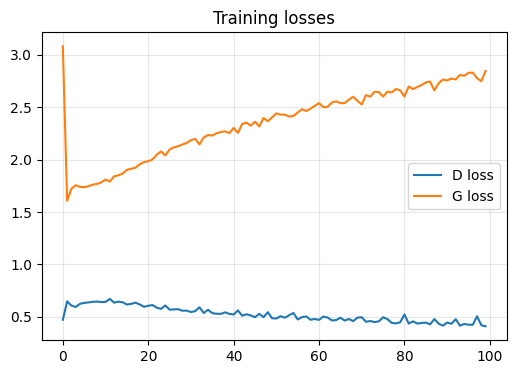

In [9]:
train_d_losses, train_g_losses = [], []

for epoch in range(1, EPOCHS+1):
    d_loss_epoch, g_loss_epoch = 0.0, 0.0
    n_batches = 0

    for batch_idx, (real_imgs, _) in enumerate(train_loader):
        bs = real_imgs.size(0)

        d_loss = train_discriminator(real_imgs)
        g_loss = train_generator(bs)

        d_loss_epoch += d_loss
        g_loss_epoch += g_loss
        n_batches += 1

        if batch_idx % LOG_INTERVAL == 0:
            print(f"Epoch {epoch} [{batch_idx}/{len(train_loader)}] D={d_loss:.3f} G={g_loss:.3f}")

    d_loss_epoch /= n_batches
    g_loss_epoch /= n_batches
    train_d_losses.append(d_loss_epoch)
    train_g_losses.append(g_loss_epoch)

    div = mode_collapse_check()
    print(f"==> Epoch {epoch}: D={d_loss_epoch:.3f} G={g_loss_epoch:.3f} | diversity(std)={div:.4f}")

    if epoch % SAVE_PLT_INTERVAL == 0:
        show_samples(epoch)
        plt.figure(figsize=(6,4))
        plt.plot(train_d_losses, label="D loss")
        plt.plot(train_g_losses, label="G loss")
        plt.legend(); plt.grid(True, alpha=0.3)
        plt.title("Training losses")
        plt.show()
